In [98]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [99]:
input_shape = (224,224,3)
resnet_weights_path = 'imagenet'
num_classes = 300
image_size = 224
batch_size = 64

In [100]:
data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)
train_generator = data_generator.flow_from_directory('/Users/brycemartin/Documents/AI/bird-class-data-2/train',
                                                    target_size = (image_size,image_size),
                                                    batch_size = batch_size, 
                                                    shuffle = True, 
                                                    class_mode = 'categorical')

test_generator = data_generator.flow_from_directory('/Users/brycemartin/Documents/AI/bird-class-data-2/test',
                                                    target_size = (image_size,image_size),
                                                    batch_size = batch_size, 
                                                    shuffle = False,
                                                    class_mode = 'categorical')

Found 43622 images belonging to 300 classes.
Found 1500 images belonging to 300 classes.


In [101]:
base_model = ResNet50(include_top=False, pooling='avg', weights=resnet_weights_path, input_shape=input_shape)
base_model.trainable = True  # Fine-tune the entire base model

inputs = tf.keras.Input(shape=input_shape)
x = base_model(inputs, training=True)
outputs = Dense(num_classes, activation='softmax')(x)
my_new_model = Model(inputs, outputs)

In [102]:
my_new_model.layers[0].trainable = True

In [103]:
with tf.device('/GPU:0'):    
    base_model.trainable = False
    my_new_model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
        metrics=['accuracy']
    )
    history = my_new_model.fit(
        train_generator,
        steps_per_epoch=100,
        validation_data=test_generator,
        epochs=5
    )

    # Unfreeze the base model and fine-tune the entire model
    base_model.trainable = True
    my_new_model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),  # Lower learning rate
        metrics=['accuracy']
    )
    history_finetune = my_new_model.fit(
        train_generator,
        steps_per_epoch=100,
        validation_data=test_generator,
        epochs=5
    )

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 64s 576ms/step - accuracy: 0.1072 - loss: 5.1097 - val_accuracy: 0.5673 - val_loss: 2.3785
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 54s 543ms/step - accuracy: 0.6150 - loss: 2.0820 - val_accuracy: 0.7987 - val_loss: 1.2592
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 55s 547ms/step - accuracy: 0.7689 - loss: 1.2752 - val_accuracy: 0.8660 - val_loss: 0.8606
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 595ms/step - accuracy: 0.8332 - loss: 0.9133 - val_accuracy: 0.9067 - val_loss: 0.6475
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 63s 634ms/step - accuracy: 0.8685 - loss: 0.7423 - val_accuracy: 0.9213 - val_loss: 0.5368
Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 279s 3s/step - accuracy: 0.8100 - loss: 0.8951 - val_accuracy: 0.9213 - val_loss: 0.3833
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 274s 3s/step - accuracy: 0.9055 - loss: 0.4934 - val_accuracy: 0.9553 - val_loss: 0.2447
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 286s 3s/step - accuracy: 0.9258 - loss: 0.4063 - val_ac

In [ ]:
my_new_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 200)            │       409,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,941,906 (182.88 MB)

 Trainable params: 23,944,392 (91.34 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 23,944,394 (91.34 MB)

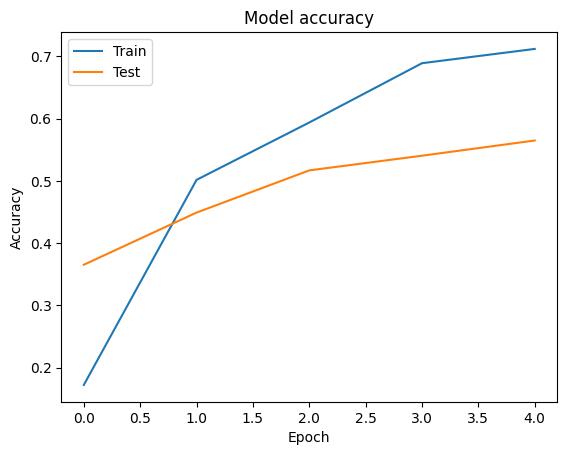

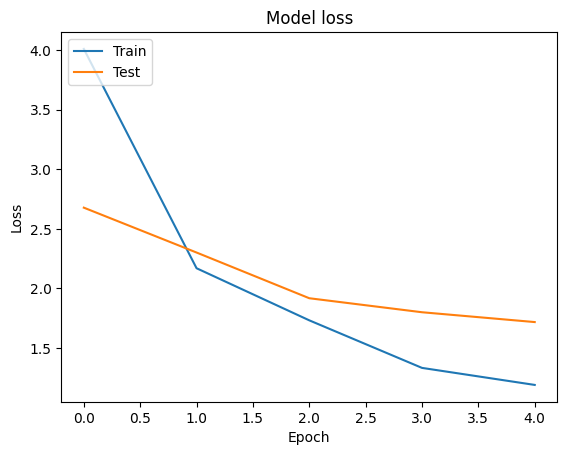

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [ ]:
my_new_model.evaluate(test_generator)

38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 606ms/step - accuracy: 0.6970 - loss: 1.1347


[1.1426944732666016, 0.6937658190727234]

In [ ]:
my_new_model.save("./bird-classification.keras")